### Imports 

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

### Const and Func

In [3]:
path = Path('data/csi_analyze/').expanduser()

In [64]:
path

PosixPath('data/csi_analyze')

In [5]:
! ls {path}

bs_avg_kpi.csv	bs_chnn_kpi.csv  test  train


In [6]:
! ls {path/'train'}

subs_bs_consumption_train.csv	 subs_csi_train.csv
subs_bs_data_session_train.csv	 subs_features_train.csv
subs_bs_voice_session_train.csv


In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

### Loads

In [9]:
train_ids = pd.read_csv(path/'train/subs_csi_train.csv', sep=';')

In [8]:
test_ids = pd.read_csv(path/'test/subs_csi_test.csv', sep=';')

In [10]:
features_train = pd.read_csv(path/'train/subs_features_train.csv', sep=';', decimal=',', 
                              parse_dates=['SNAP_DATE'], infer_datetime_format=True, dayfirst=True)

In [11]:
features_test = pd.read_csv(path/'test/subs_features_test.csv', sep=';', decimal=',', 
                              parse_dates=['SNAP_DATE'], infer_datetime_format=True, dayfirst=True)

In [13]:
# convert to months (int)
features_train.SNAP_DATE = features_train.SNAP_DATE.dt.month

In [14]:
# convert to months (int)
features_test.SNAP_DATE = features_test.SNAP_DATE.dt.month

###  Data processing

In [21]:
train_ids.SK_ID.nunique(), features_train.SK_ID.nunique()

(3754, 3622)

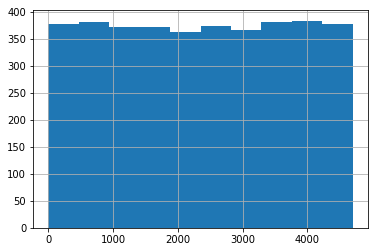

In [22]:
train_ids.SK_ID.hist();

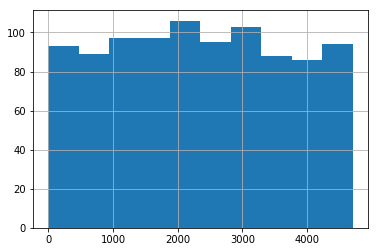

In [23]:
test_ids.SK_ID.hist();

#### Get same distribution of ids for validation as in test

In [67]:
train_ids.describe()

,SK_ID,CSI,CONTACT_DATE
count,3754.000000,3754.000000,3754.000000
mean,2354.045818,0.156899,14.958364
std,1363.579050,0.363754,8.857586
min,2.000000,0.000000,1.050000
25%,1174.250000,0.000000,8.050000
50%,2360.500000,0.000000,13.050000
75%,3549.500000,0.000000,23.050000
max,4701.000000,1.000000,31.050000


In [68]:
test_ids.describe()

,SK_ID,CONTACT_DATE
count,948.000000,948.000000
mean,2341.418776,15.333755
std,1333.791553,8.872241
min,1.000000,1.050000
25%,1182.750000,8.050000
50%,2329.000000,14.050000
75%,3462.250000,23.050000
max,4702.000000,31.050000


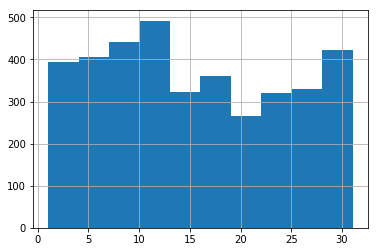

In [84]:
train_ids.CONTACT_DATE.hist()

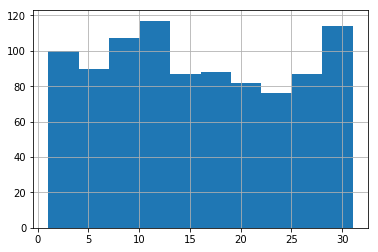

In [85]:
test_ids.CONTACT_DATE.hist();

In [86]:
tr_ids, val_ids = sklearn.model_selection.train_test_split(
    train_ids, test_size=0.1, stratify=train_ids.CSI, random_state=111)

In [87]:
tr_ids.CSI.mean(), val_ids.CSI.mean()

(0.15689757252812314, 0.15691489361702127)

In [88]:
val_ids.shape

(376, 3)

### Pivoting feature tables

In [103]:
# to merge column names later on
features_train.SNAP_DATE = features_train.SNAP_DATE.astype(str)

In [127]:
# to merge column names later on
features_test.SNAP_DATE = features_test.SNAP_DATE.astype(str)

In [143]:
tr_pivot = features_train.pivot(index='SK_ID', columns='SNAP_DATE')

In [144]:
test_pivot = features_test.pivot(index='SK_ID', columns='SNAP_DATE')

In [158]:
tr_pivot.head()

,SK_ID,COM_CAT#1_1,COM_CAT#1_10,COM_CAT#1_11,COM_CAT#1_12,COM_CAT#1_2,COM_CAT#1_3,COM_CAT#1_4,COM_CAT#1_5,COM_CAT#1_6,...,COM_CAT#34_2,COM_CAT#34_3,COM_CAT#34_4,COM_CAT#34_5,COM_CAT#34_6,COM_CAT#34_7,COM_CAT#34_8,COM_CAT#34_9,CSI,CONTACT_DATE
0,2,7.0,NaN,NaN,NaN,7.0,7.0,7.0,7.0,NaN,...,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN,0,4
1,3,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,...,9.0,9.0,9.0,9.0,NaN,NaN,NaN,NaN,0,21
2,4,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0,27
3,5,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,8
4,6,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1,6


In [159]:
test_pivot.head()

,SK_ID,CONTACT_DATE,COM_CAT#1_1,COM_CAT#1_10,COM_CAT#1_11,COM_CAT#1_12,COM_CAT#1_2,COM_CAT#1_3,COM_CAT#1_4,COM_CAT#1_5,...,COM_CAT#34_11,COM_CAT#34_12,COM_CAT#34_2,COM_CAT#34_3,COM_CAT#34_4,COM_CAT#34_5,COM_CAT#34_6,COM_CAT#34_7,COM_CAT#34_8,COM_CAT#34_9
0,308,27,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,1789,26,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,3386,22,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0
3,2429,9,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,693,29,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,10.0,9.0,9.0,NaN,NaN,NaN,NaN


In [147]:
tr_pivot.columns = ['_'.join(col) for col in tr_pivot.columns]

In [148]:
test_pivot.columns = ['_'.join(col) for col in test_pivot.columns]

In [149]:
tr_pivot.reset_index(inplace=True)

In [150]:
test_pivot.reset_index(inplace=True)

In [151]:
# add contact date and labels
tr_pivot = pd.merge(tr_pivot, train_ids, on='SK_ID')

In [152]:
test_pivot = pd.merge(test_ids, test_pivot, on='SK_ID', how='left')

In [153]:
tr_pivot['CONTACT_DATE'] = pd.to_datetime(tr_pivot['CONTACT_DATE'], format='%d.%m')

In [154]:
test_pivot['CONTACT_DATE'] = pd.to_datetime(test_pivot['CONTACT_DATE'], format='%d.%m')

#### Process with fastai structured

In [157]:
tr_pivot['CONTACT_DATE'] = tr_pivot['CONTACT_DATE'].dt.day
test_pivot['CONTACT_DATE'] = test_pivot['CONTACT_DATE'].dt.day

In [160]:
train_cats(tr_pivot)

In [161]:
apply_cats(test_pivot, tr_pivot)

In [162]:
tr_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3622 entries, 0 to 3621
Columns: 411 entries, SK_ID to CONTACT_DATE
dtypes: category(12), float64(396), int64(3)
memory usage: 11.1 MB


In [163]:
test_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 948 entries, 0 to 947
Columns: 410 entries, SK_ID to COM_CAT#34_9
dtypes: category(12), float64(396), int64(2)
memory usage: 2.9 MB


In [164]:
os.makedirs('data/tmp', exist_ok=True)

In [165]:
tr_pivot.to_feather('data/tmp/train-features-raw')

In [166]:
test_pivot.to_feather('data/tmp/test-features-raw')

### Train

In [168]:
df, y, nas = proc_df(tr_pivot, 'CSI')

In [187]:
test, _, _ = proc_df(test_pivot, na_dict=nas)

In [169]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=10)
m.fit(df, y)
m.score(df, y)

0.9748757592490337

In [170]:
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    df, y, test_size=0.1, stratify=y, random_state=111)

In [173]:
X_valid.shape

(363, 806)

In [174]:
def print_score(m):
    res = [metrics.roc_auc_score(y_train, m.predict_proba(X_train)[:,1]), 
           metrics.roc_auc_score(y_valid, m.predict_proba(X_valid)[:,1]),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [186]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf=12, max_features=0.1, random_state=111)
m.fit(X_train, y_train)
print_score(m)

[0.9919163253448281, 0.5395596835225318, 0.8441239644062596, 0.8429752066115702]


### Predict on test and submit

In [188]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf=12, max_features=0.1, random_state=111)
m.fit(df, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=111, verbose=0, warm_start=False)

In [189]:
pred_y = m.predict_proba(test)[:,1]

In [190]:
subm = pd.DataFrame(pred_y)

In [191]:
subm.to_csv('submits/rf_on_rand_str_sample.csv', index=False, header=False)